In [ ]:
# Import Required Libraries
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/'Colab Notebooks'/'Computational Analysis of Moonlighting Proteins'/

/content/drive/MyDrive/Colab Notebooks/Computational Analysis of Moonlighting Proteins


In [ ]:
from transformers import T5EncoderModel, T5Tokenizer
import torch
import re
import pandas as pd
from tqdm import tqdm  # Para mostrar el progreso en loops

# Configurar el dispositivo (GPU si está disponible, si no, CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cargar el modelo y el tokenizador
tokenizer = T5Tokenizer.from_pretrained('Rostlab/ProstT5', do_lower_case=False)
model = T5EncoderModel.from_pretrained("Rostlab/ProstT5").to(device)
model.float() if device.type == 'cpu' else model.half()  # Ajustar precisión

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.60k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/283 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

T5EncoderModel(
  (shared): Embedding(150, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(150, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=4096, bias=False)
              (k): Linear(in_features=1024, out_features=4096, bias=False)
              (v): Linear(in_features=1024, out_features=4096, bias=False)
              (o): Linear(in_features=4096, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=16384, bias=False)
              (wo): Linear(in_features=16384, out_features=1024, bias=False)
              (dropout): Dropo

In [ ]:
# Simulación de un DataFrame con secuencias de proteínas
df = pd.read_csv("../predictor_dataset.csv")

In [ ]:
df.sort_values(by="Amino Acid Sequence", inplace=True)

In [ ]:
df_non_human.shape[0]

599

In [ ]:

gc.collect()  # Force garbage collection
torch.cuda.empty_cache()  # Clear CUDA cache

# Print GPU memory usage
print(" ")
print(f"GPU Memory Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"GPU Memory Reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

 
GPU Memory Allocated: 2.42 GB
GPU Memory Reserved: 2.47 GB


In [ ]:
import torch
import gc
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

def process_batch(batch):
    """Encodes sequences and extracts embeddings in full precision (FP32)."""
    batch = [preprocess_sequence(seq) for seq in batch]
    ids = tokenizer.batch_encode_plus(batch, add_special_tokens=True, padding="longest", truncation=True, return_tensors='pt').to(device)

    with torch.no_grad():
        embedding_repr = model(ids.input_ids, attention_mask=ids.attention_mask).last_hidden_state
        batch_embeddings = embedding_repr[:, 1:-1, :].mean(dim=1).cpu().numpy()

    del ids, embedding_repr
    torch.cuda.empty_cache()
    gc.collect()

    return batch_embeddings

def process_single_sequence_fp16(sequence):
    """Processes a single sequence using FP16 precision to save memory."""
    batch = [preprocess_sequence(sequence)]
    ids = tokenizer.batch_encode_plus(batch, add_special_tokens=True, padding="longest", truncation=True, return_tensors='pt').to(device)

    with torch.no_grad():
        model.half()  # Switch to FP16
        embedding_repr = model(ids.input_ids, attention_mask=ids.attention_mask).last_hidden_state
        batch_embedding = embedding_repr[:, 1:-1, :].mean(dim=1).cpu().numpy()
        model.float()  # Switch back to FP32

    del ids, embedding_repr
    torch.cuda.empty_cache()
    gc.collect()

    return batch_embedding[0]

def get_prott5_embeddings(sequences, initial_batch_size=8):
    batch_size = initial_batch_size
    embeddings = [None] * len(sequences)  # Initialize with None to maintain order
    i = 0

    while i < len(sequences):
        print(f"Processing sequence {i+1}/{len(sequences)}")
        try:
            batch = sequences[i:i+batch_size]
            batch_embeddings = process_batch(batch)

            # Save embeddings in the correct positions
            embeddings[i:i+batch_size] = batch_embeddings
            i += batch_size  # Move to next batch

            # Restore batch size after a successful run
            if batch_size < initial_batch_size:
                print(f"✅ Restoring batch size to {initial_batch_size}.")
                batch_size = initial_batch_size

        except torch.cuda.OutOfMemoryError:
            if batch_size > 1:
                print(f"⚠️ Reducing batch size from {batch_size} to {max(1, batch_size // 2)} due to OOM.")
                batch_size = max(1, batch_size // 2)  # Reduce batch size but keep at least 1
            else:
                print(f"⚠️ Running sequence {i+1} in FP16 due to OOM.")
                torch.cuda.empty_cache()

                try:
                    embedding = process_single_sequence_fp16(sequences[i])
                    embeddings[i] = embedding  # Save even the fallback embedding
                    i += 1  # Move to next sequence

                except torch.cuda.OutOfMemoryError:
                    print(f"❌ Skipping sequence {i+1} (too large for FP16).")
                    i += 1  # Still move forward, but keep None as a placeholder

    return embeddings


In [ ]:
df["embedding"] = get_prott5_embeddings(df["Amino Acid Sequence"].tolist())  # Further reduce batch size if needed

Processing sequence 1/1261
Processing sequence 9/1261
Processing sequence 17/1261
Processing sequence 25/1261
Processing sequence 33/1261
Processing sequence 41/1261
⚠️ Reducing batch size from 8 to 4 due to OOM.
Processing sequence 41/1261
⚠️ Reducing batch size from 4 to 2 due to OOM.
Processing sequence 41/1261
✅ Restoring batch size to 8.
Processing sequence 43/1261
Processing sequence 51/1261
⚠️ Reducing batch size from 8 to 4 due to OOM.
Processing sequence 51/1261
✅ Restoring batch size to 8.
Processing sequence 55/1261
Processing sequence 63/1261
Processing sequence 71/1261
Processing sequence 79/1261
Processing sequence 87/1261
Processing sequence 95/1261
Processing sequence 103/1261
⚠️ Reducing batch size from 8 to 4 due to OOM.
Processing sequence 103/1261
✅ Restoring batch size to 8.
Processing sequence 107/1261
⚠️ Reducing batch size from 8 to 4 due to OOM.
Processing sequence 107/1261
✅ Restoring batch size to 8.
Processing sequence 111/1261
Processing sequence 119/1261
P

In [ ]:
df_enveddings_clean = df.dropna(subset=["embedding"])

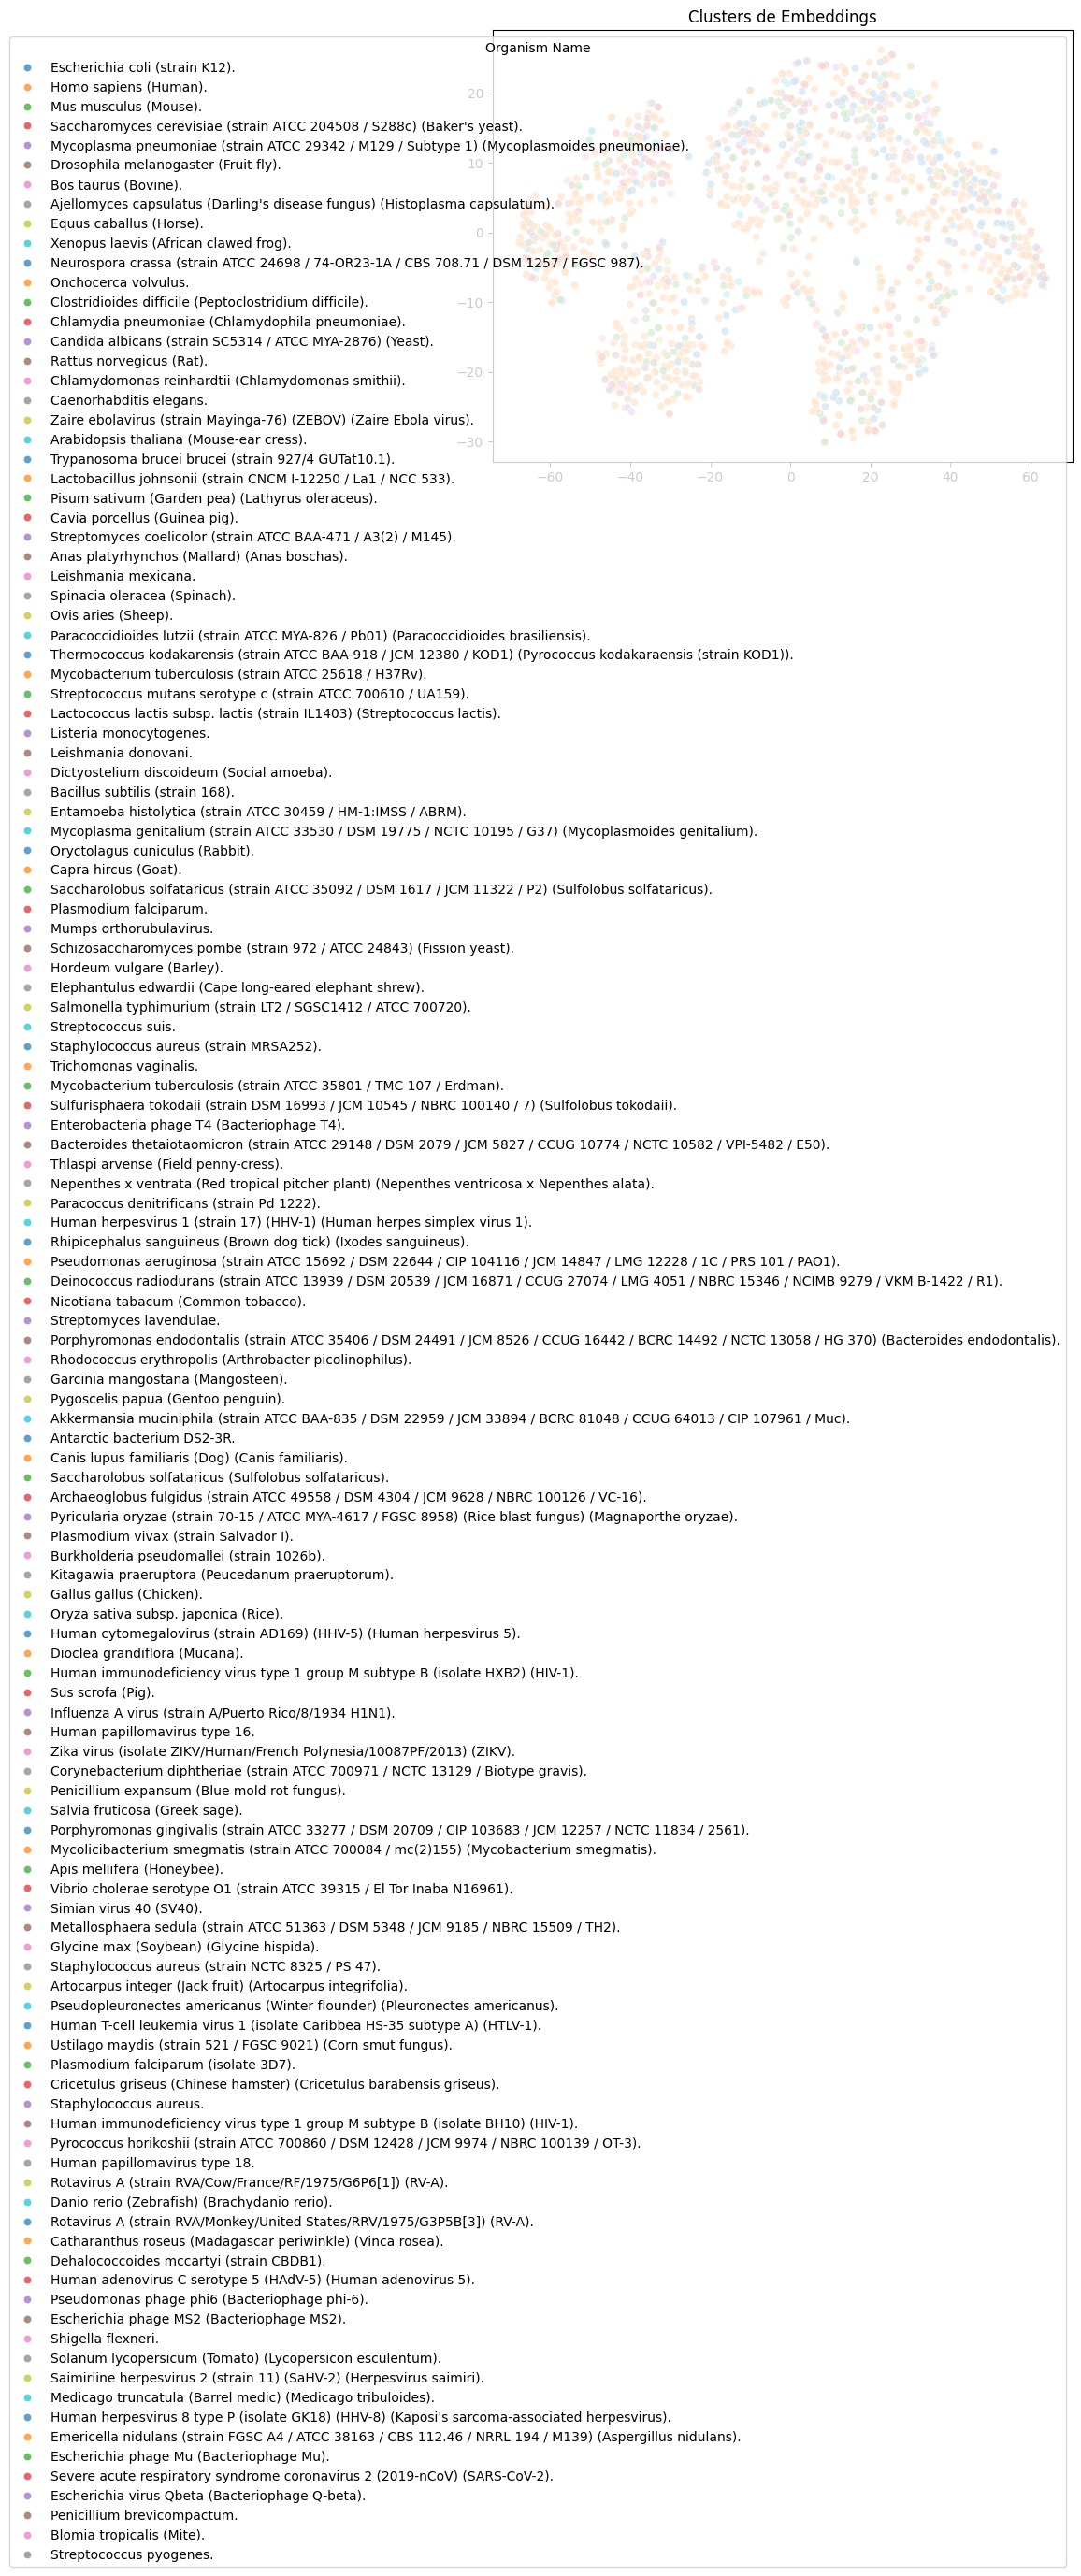

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convertir a matriz NumPy
X = np.vstack(df_enveddings_clean["embedding"].values)
y_labels = df_enveddings_clean["Organism Name"]

# Reducir dimensionalidad con t-SNE
X_embedded = TSNE(n_components=2, perplexity=30, random_state=2025).fit_transform(X)

# Visualizar
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_labels, palette="tab10", alpha=0.7)
plt.title("Clusters de Embeddings")
plt.show()